In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
from datetime import date, timedelta


sns.set_style("darkgrid")

In [11]:
def get_data(ticker, interval):
    data_size = {
        "1m": 60*24*7*12,
        "1h": 24*729,
        "1d": 252*4,
    }
    num_data_full = data_size[interval]

    end_date = date.today()
    delta = {
        "1m": end_date - timedelta(minutes=num_data_full),
        "1h": end_date - timedelta(hours=num_data_full),
        "1d": end_date - timedelta(days=num_data_full),
    }
    start_date = delta[interval]

    df = yf.download(ticker, start=start_date.strftime("%Y-%m-%d"), end=end_date.strftime("%Y-%m-%d"), interval=interval)
    return df


def typical_price(high, low, close):
    """Linear approximation of the mean price in the time interval."""
    return (high + low + close) / 3


def vwap(df_input):
    df = df_input.copy()
    df["cumulative volume"] = df["Volume"].cumsum()
    df["typical_price"] = typical_price(df["High"], df["Low"], df["Close"])
    df["volume * typical_price"] = df["Volume"] * df["typical_price"]
    df["cumulative(volume * typical_price)"] = df["volume * typical_price"].cumsum()
    df["VWAP"] = df["cumulative(volume * typical_price)"] / df["cumulative volume"]
    
    # If volume == 0 in leading row -> div by 0.
    df.dropna(inplace=True)
    
    return df


def plot_vwap(df, ticker, interval, boundary=1.0):
    fig = plt.figure()
    fig.set_size_inches(8, 5)

    opacity = 0.2
    plt.plot(df["VWAP"], color="black", label="VWAP")
    plt.plot(df["VWAP"] * boundary, color="black", linestyle="dotted", label="VWAP * b")
    plt.plot(df["VWAP"] / boundary, color="black", linestyle="dotted", label="VWAP / b")
    plt.plot(df["Open"], color="orange", label="Open", alpha=opacity)
    plt.plot(df["High"], color="green", label="High", alpha=opacity)
    plt.plot(df["Low"], color="purple", label="Low", alpha=opacity)
    plt.plot(df["Close"], color="red", label="Close")
    plt.plot(df["Close"], color="magenta", label="Adj Close", alpha=opacity)

    plt.title(f"VWAP OHLC Prices of {ticker}")
    plt.xlabel(f"Time Step ({interval})")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

[*********************100%***********************]  1 of 1 completed


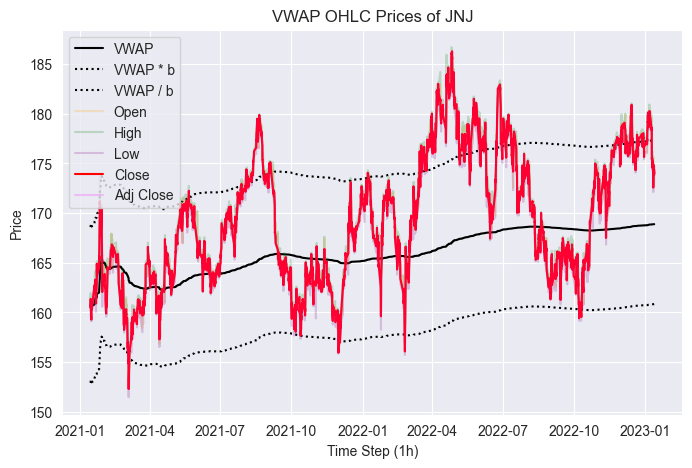

In [12]:
ticker = "JNJ"
interval = "1h"
b = 1.05

df_raw = get_data(ticker, interval)
df = df_raw.pipe(vwap)

plot_vwap(df, ticker, interval, b)

[*********************100%***********************]  1 of 1 completed


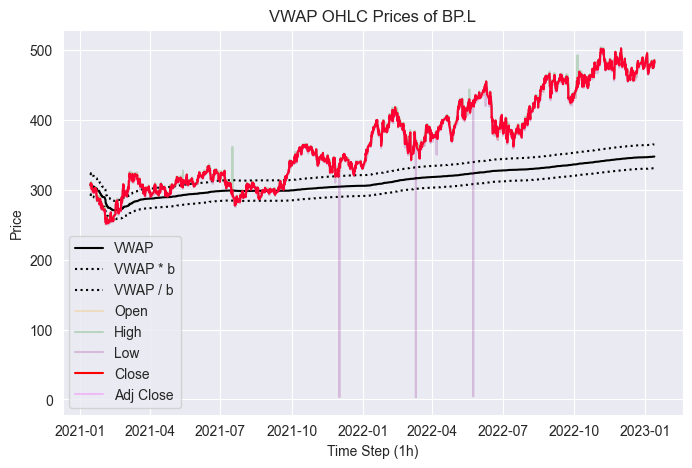

In [13]:
ticker = "BP.L"  # BP on LSE.
interval = "1h"
b = 1.05

df_raw = get_data(ticker, interval)
df = df_raw.pipe(vwap)

plot_vwap(df, ticker, interval, b)

[*********************100%***********************]  1 of 1 completed


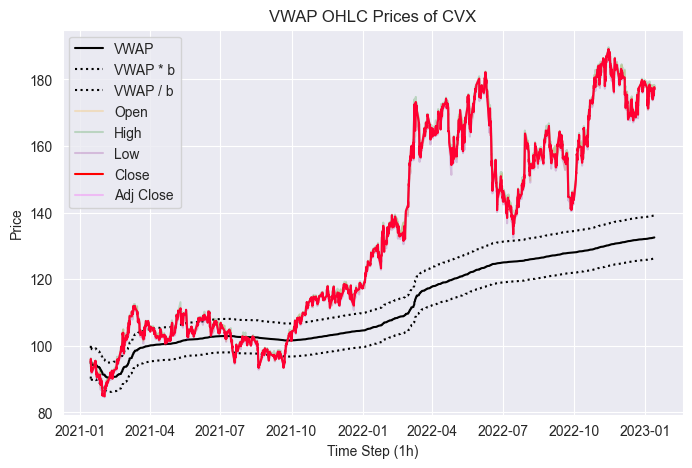

In [14]:
ticker = "CVX" # Chevron
interval = "1h"
b = 1.05

df_raw = get_data(ticker, interval)
df = df_raw.pipe(vwap)

plot_vwap(df, ticker, interval, b)

# Notes:
- Consider sideways trending markets.
- E.g. 200 day MA constrained to region.
- JNJ profit.
- BP.L & CVX: if market continues to trend (up/down) - lose on (short/long).